<a href="https://colab.research.google.com/github/hyeonzz/ESAA_24-1_OB/blob/book_writing/0304%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **3/4 과제 - 핸즈온 3장 분류 p.127-154**





# **CHAPTER3.분류**

## **3.1 MNIST**
#### - MNIST: 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋. 학습용 데이터셋으로 많이 사용됨.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

#### 사이킷런에서 읽어들인 데이터셋 -> 비슷한 딕셔너리 구조를 가짐
*   데이터셋을 설명하는 DESCR 키
*   샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
*  레이블 배열을 담은 target 키


In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### -> 이미지가 70,000개 있고, 각 이미지에는 784개의 특성이 있다. (이미지가 28X28 픽셀이기 때문)

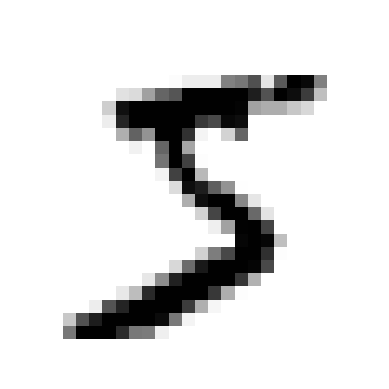

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
import numpy as np
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## **3.2 이진 분류기 훈련**
#### - 이진 분류기: 두 개의 클래스를 구분하는 것

In [10]:
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

#### SGDClassifier클래스(확률적 경사 하강법 분류기): 매우 큰 데이터셋을 효율적으로 처리함.

In [11]:
# SGDClassifier 클래스(확률적 경사 하강법 분류기) 모델 생성 및 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## **3.3성능 측정**
- 정확도, 오차 행렬, 정밀도/재현율, 정밀도/재현율 트레이드오프, ROC 곡선

### 3.3.1 교차 검증을 사용한 정확도 측정
#### - 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야할 때 => 교차 검증 기능을 직접 구현

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


##### => StratifiedKFold
*  클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행
* 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦.
* 올바른 예측의 수를 세어 정확한 예측의 비율 출력

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])


* cross_val_score() 함수로 폴드가 3개인 k-겹 교차검증을 사용해 SGDClassifier 모델 평가함
* k-겹 교차 검증: 훈련 세트 k개 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델 사용

In [15]:
# 모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기 생성
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#모델의 정확도: 90%이상으로 나옴.

array([0.91125, 0.90855, 0.90915])

#### => (위의 예시를 통해) 분류기의 성능 측정 지표로 정확도 선호X.
#### => 특히 불균형 데이터셋을 다룰 때(어떤 클래스가 다른 것보다 월등히 많은 경우) 더 그럼.

### 3.3.2 오차 행렬
- 정확도보다 분류기의 성능을 평가하기 더 좋음.
- 기본적인 아이디어: 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
- 예를 들어, 분류기가 5의 이미지를 3으로 잘못 분류한 횟수를 알려면, 오차 행렬의 5행 3열 확인


#### 오차 행렬을 만들기 위해..
+ 실제 타깃과 비교할 수 있도록 예측값 먼저 생성.
+ 테스트 세트로 예측을 만들 수 있지만 여기서 사용x.(프로젝트 맨 마지막에 사용!)
+ 대신 cross_val_predict()함수 사용함.  

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#### cross_val_predict() 함수
- k-겹 교차 검증을 수행하지만 평가 점수를 반환x. 각 테스트 폴드에서 얻은 예측을 반환함.
- 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻음.(모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미)

In [18]:
#confusion_matrix()함수를 이용해 오차행렬 만들기 -> 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호츌
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

#### 오차 행렬
- 행: 실제 클래스
- 열: 예측한 클래스

#### 위의 오차행렬에서
- 1행: '5 아님' 이미지에 대한 것 (음성 클래스)
- 1행 1열: '5 아님' 이미지를 '5아님'이미지로 정확하게 분류 (진짜 음성)
- 1행 2열: '5 아님' 이미지를 '5'이미지로 잘못 분류(거짓 양성)
---
- 2행: '5' 이미지에 대한 것 (양성 클래스)
- 2행 1열: '5'이미지를 '5 아님'이미지로 잘못 분류(거짓 음성)
- 2행 2열: '5'이미지를 '5'이미지로 정확하게 분류
---
=> 완벽한 분류기: 진짜 양성과 진짜 음성만 가지고 있음. 따라서 오차 행렬의 주대각선만 0이 아닌 값이 됨.

In [19]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 정밀도
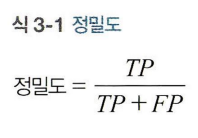

#### TP: 진짜 양성 수, FP: 거짓 양성 수

#### 재현율
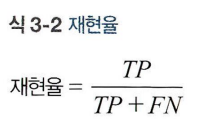
#### TP: 진짜 양성 수, FN: 거짓 음성 수
#### 재현율 = 민감도, 진짜 양성 비율 (분류기가 정확하게 감지한 양성 샘플의 비율)

#### => 정밀도와 재현율을 같이 사용하는 것이 일반적
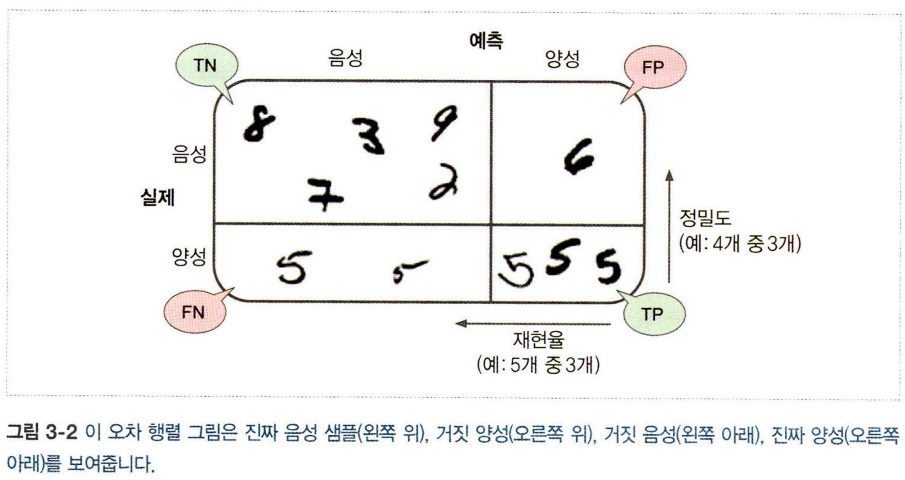

### 3.3.3 정밀도와 재현율

In [20]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
# 정확도보다 수치가 낮음

0.8370879772350012
0.6511713705958311


#### F1 score
- 정밀도와 재현율의 조화 평균
- 두 분류기를 비교할 때 F1 score를 쓰면 편리함.
- f1_score() 함수 사용해서 구할 수 있음
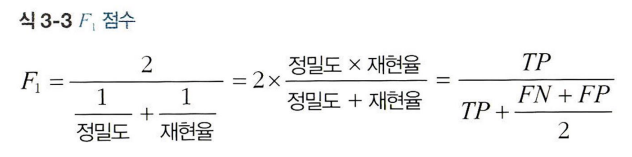


In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

##### 정밀도와 재현율이 비슷한 분류기에서는 f1 score가 높음. -> 항상 바람직한 건 x, 상황에 따라 정밀도 or 재현율이 중요할 수도 있음
##### 예시1> 어린아이 동영상 - 좋은 동영상 많이 제외되어도(낮은 재현율) 안전한 것들만 노출(높은 정밀도)  
##### 예시2> 도둑 감시 카메라 - 경비원이 종종 잘못 호출되어도 검거율은 높을 때(높은 재현율, 낮은 정밀도)
##### => 정밀도/재현율 트레이드오프: 정밀도와 재현율이 반비례 관계

### 3.3.4 정밀도/재현율 트레이드오프
#### SGDClassifier는 결정 함수를 사용해 각 샘플의 점수를 계산함.
- 계산값 > 임계값; 샘플을 양성 클래스에 할당
- 계산값 <= 임계값: 음성 클래스에 할당
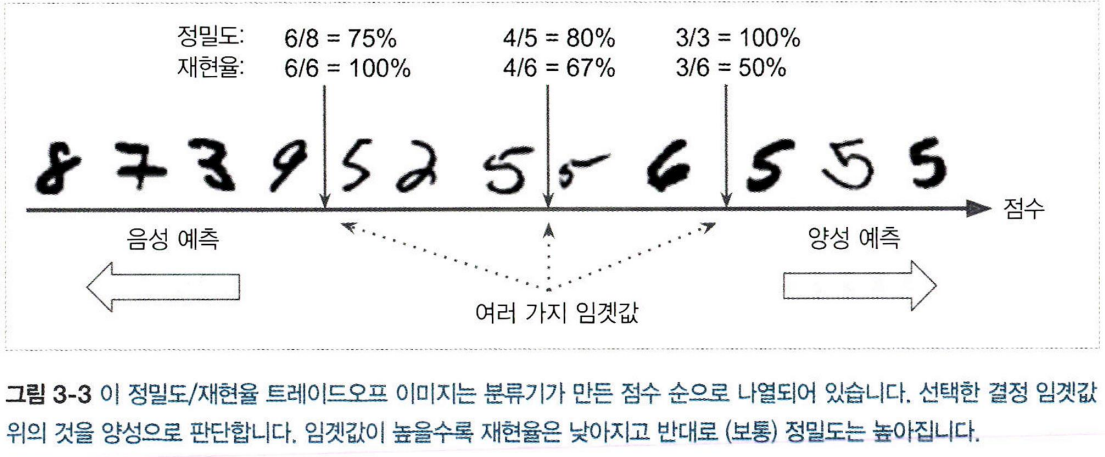

##### decision_function(): 각 샘플의 점수를 얻을 수 있음. 이 점수를 기반으로 원하는 임곗값을 정해 예측 가능

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [24]:
# 임계값을 높임
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#-> 재현율이 줄어듦.

array([False])

In [25]:
#적절한 임곗값 정하는 방법
#-> cross_val_predict 함수를 통해 훈련 세트에 있는 모든 샘플의 점수를 구함. (결정 점수를 반환받도록 지정)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

##### precision_recall_curve(): 가능한 모든 임곗값에 대해 정밀도와 재현율 계산

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

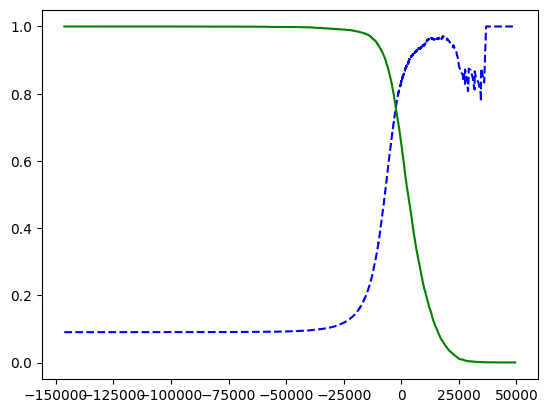

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

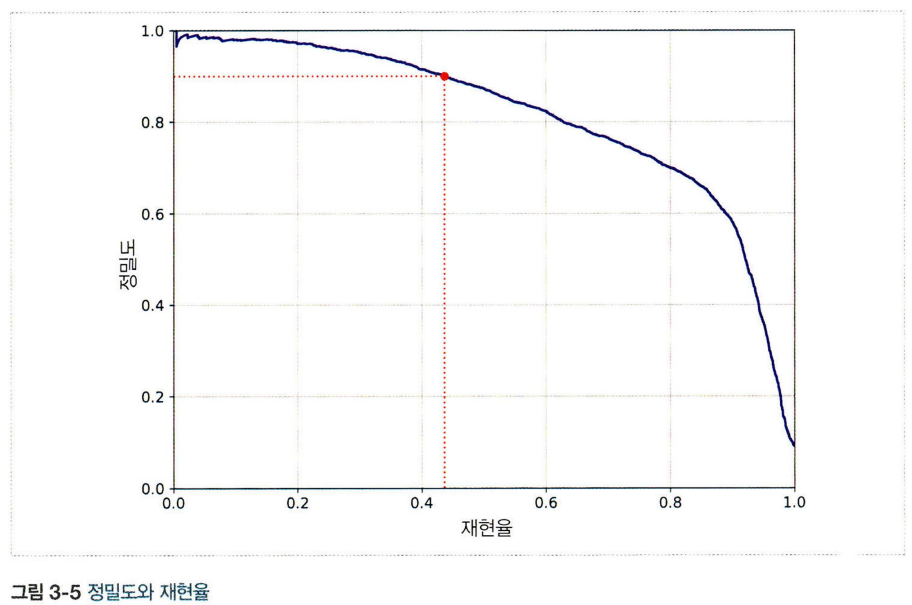

##### -재현율 80% 근처에서 정밀도가 급격하게 줄어듦. -> 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 굳

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #~7816

In [29]:
# 훈련 세트에 대한 예측 만들기
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


##### ! 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않음. -> 재현율 얼마에서 정밀도 얼마를 달성할 것인가?

### 3.3.5 ROC 곡선
-  이진 분류에 많이 사용됨.
- 거짓 양성 비율에 대한 진짜 양성 비율(TPR/FPR = TPR/1-TNR)
- 민감도(재현율)에 대한 1-특이도

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

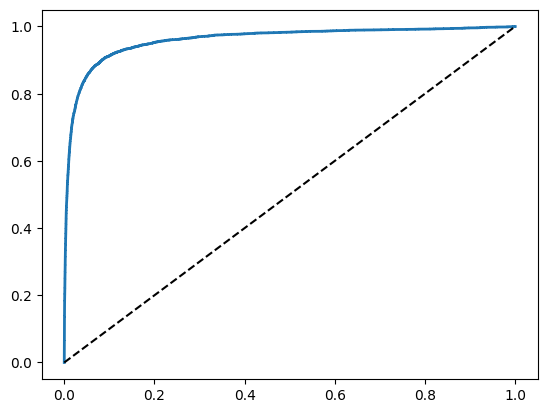

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') #대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

##### 곡선 아래의 면적(AUC)를 측정하여 분류기 비교할 수 있음.
##### - 완벽한 분류기: ROC의 AUC가 1
##### - 완전한 랜덤 분류기: ROC의 AUC 가 0.5
##### roc_auc_score(): ROC의 AUC를 계산하는 함수

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
#randomforestclassifier를 훈련시킨 후 sgdclassifier의 roc곡선 & roc auc 점수 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")  #decision_function() 메서드 대신 predict_proba() 메서드

In [36]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

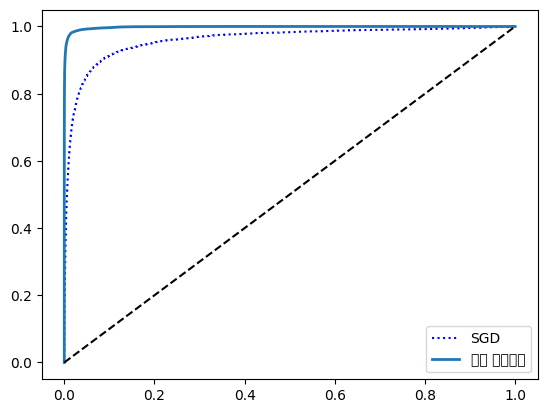

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

##### => RandomForestClassifier의 ROC 곡선이 SGDClassifier보다 좋음. ROC AUC 점수도 훨씬 높음.

## **3.4 다중 분류**
- 둘 이상의 클래스를 구별
- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등 -> 여러 개의 클래스를 직접 처리 가능
- 로지스틱 회귀, 서포트 벡터 머신 분류기 -> 이진분류만 가능 (이진 분류기를 여러 개 사용해 다중 클래스 분류하는 법도 있음)
> - OvR(OvA)전략: 특정 숫자 하나만 구분한느 숫자별 이진 분류기 10개를 훈련 후 클래스가 10개인 숫자 이미지 분류 시스템을 만듦. 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요함.
> - OvO전략: 0과 1, 1과 2 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시킴. 클래스가 N개일 때 분류기는 Nx(N-1)/2개 필요.

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)  #y_train_5(5를 구별한 타깃 클래스)가 아니고 y_train(원래 타깃 클래스)을 사용.
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
#샘플당 10개의 점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]

5

In [42]:
#SVC 기반으로 OvR전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [43]:
#SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [44]:
#SGDClassifier가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])
#대부분은 점수가 큰 음수이지만 클래스 5와 3은 그렇지 않음. -> 클래스 3을 조금 의하고 있음.

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [45]:
#SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
#모든 테스트 폴드에서 84% 이상의 점수. 나쁘진 않지만 성능을 더 높일 수 있음.

array([0.87365, 0.85835, 0.8689 ])

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## **3.5 에러 분석**
- 가능성이 높은 모델 하나를 찾았다고 가정했을 때 이 모델의 성능을 향상시킬 수 있는 방법 중 하나

In [48]:
#오차 행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

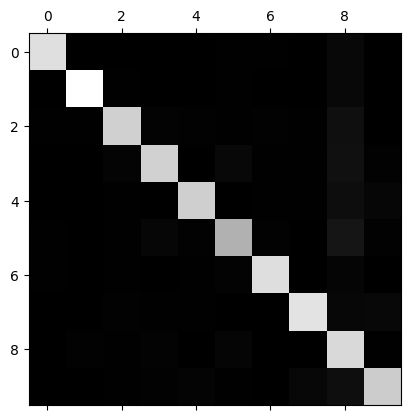

In [49]:
#오차행렬의 이미지
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

##### matshow()의 결과
- 주대각선이 있으므로 대부분의 이미지가 올바르게 분류되었음
- 숫자 5가 다른 숫자보다 어두워 보이는데, '1)데이터셋에 숫자 5의 이미지가 적거나 2)분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못함' 을 의미 -> 두 가지 경우에 대한 확인 필요

In [50]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums   # 에러 비율 비

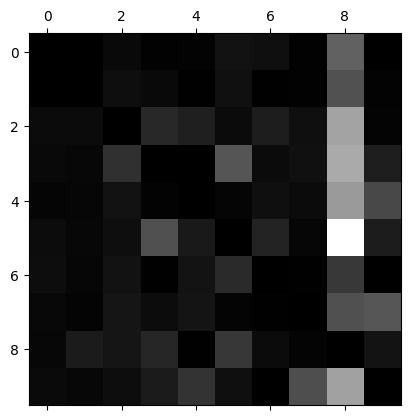

In [51]:
#주대각선만 0으로 채워 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

##### matshow()의 결과
- 행: 실제 클래스, 열: 예측한 클래스
- 클래스 8의 열이 밝음 -> 많은 이미지가 8로 잘못 분류됨을 의미
- 클래스 8의 행은 괜춘 -> 실제 8이 적절히 8로 분류되었음을 의미
- 오차 행렬이 반드시 대칭인 건 아님. (3과 5가 서로 많이 혼동되어 있음을 볼 수 있음)
> 어떻게 분류기 성능 향상? - 8로 잘못 분류되는 것을 줄여야함.
> - 8로 잘못 예측된 숫자의 훈련 데이터를 더 많이 모아 실제 8과 구분하도록 분류기 학습
> - 분류기에 도움될 만한 특성 찾아보기 (ex> 동심원의 수를 세는 알고리즘)
> - 어떤 패턴(ex>동심원)이 드러나도록 이미지 전처리  

##### 각각의 에러 분석; 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있지만, 더 어렵고 시간이 오래 걸림.

In [60]:
import matplotlib.pyplot as plt
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

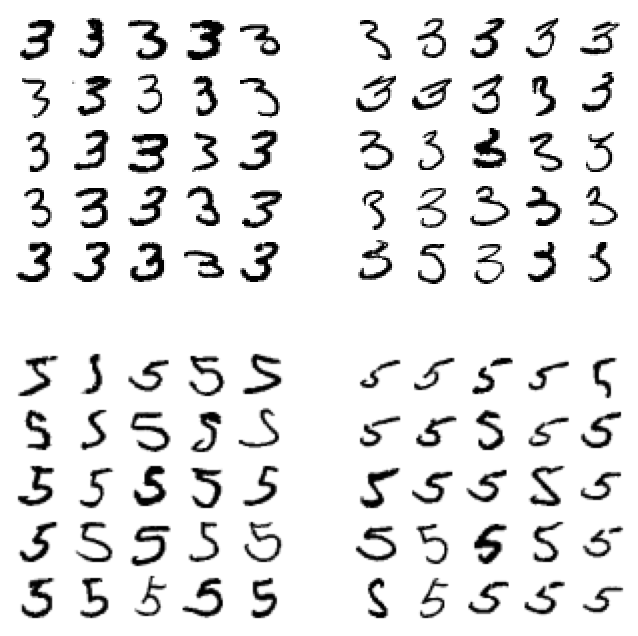

In [61]:
#각각의 에러 분석
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

##### 결과
- 왼쪽의 5x5 두 블록: 3으로 분류된 이미지
- 오른쪽의 5x5 두 믈록: 5로 분류된 이미지
- 대부분의 잘못 분류된 이미지는 확실한 에러임(사람도 분류하기 어려운 숫자가 아닌)
- 잘못 분류의 원인은 선형 모델인 SGDClassifier를 사용했기 때문. (선형 분류기는 클래스마다 픽셀에 가중치 할당 후 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함. 3과 5는 픽셀이 거의 같기 때문에 모델이 쉽게 혼동함.)

##### 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치임.숫자 3일 때 연결 부위가 조금 왼쪽으로 치우치면 5로 분류하고 반대로도 마찬가지임.
##### -> 분류기는 이미지의 위치나 회전 방향에 민감함.
##### -> 따라서 3과 5의 에러를 줄이는 방법 중 하나는 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것.

## **3.6 다중 레이블 분류**
- 분류기가 샘플마다 여러 개의 클래스를 출력할 때 여러 개의 이진 꼬리표를 출력하는 분류 시스템
- 예> 얼굴 인식 분류기 - 분류기가 a,b,c 얼굴을 인식하도록 훈련되어 있을 때 a,c가 있는 사진을 본다면 [1,0,1]을 출력

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)      #숫자가 7,8,9인지
y_train_odd = (y_train %2 == 1)      #홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [63]:
#F1 점수 구하고 F1점수의 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## **3.7 다중 출력 분류**
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

######- 이미지에서 잡음 제거 시스템 만들기

In [67]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [68]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

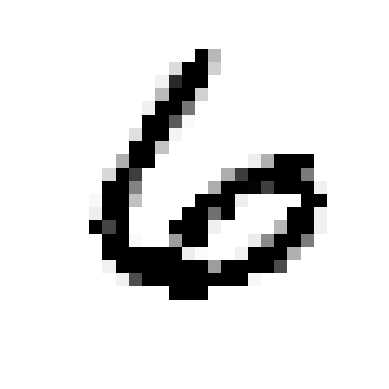

In [70]:
some_index = 5501
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)